In [ ]:
# Importing the libraries
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from skimage.morphology import remove_small_objects
from scipy.ndimage import label
from skimage.morphology import skeletonize
from numpy.lib.stride_tricks import sliding_window_view
print("Imported successfully!")

In [ ]:
def show_image(image, name="Image"):
    # plt.figure(figsize=(10, 5))
    plt.title(name)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()
    
def save_image(image_matrix, file_name):
    cv2.imwrite(file_name, image_matrix)
    print(f"Image saved as '{file_name}'")
    

In [ ]:
def adaptive_threshold(image, block_size, threshold_percentage):
    # Ensure block_size is odd
    if block_size % 2 == 0:
        raise ValueError("block_size must be an odd number")

    # Calculate padding size
    pad_size = block_size // 2

    # Pad the image to handle borders
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    # Extract sliding windows (blocks)
    blocks = view_as_windows(padded_image, (block_size, block_size))  # Shape: (rows, cols, block_size, block_size)

    # Extract the central pixel for each block
    central_pixels = blocks[:, :, pad_size, pad_size]  # Shape: (rows, cols)

    # Calculate the threshold for each block's central pixel
    thresholds = central_pixels * threshold_percentage  # Shape: (rows, cols)

    # Repeat thresholds to match the block size (for all 25 pixels in the block)
    thresholds_expanded = np.repeat(thresholds[:, :, np.newaxis, np.newaxis], block_size, axis=2)
    thresholds_expanded = np.repeat(thresholds_expanded, block_size, axis=3)  # Shape: (rows, cols, block_size, block_size)

    # Compare each pixel in the block with its corresponding threshold
    thresholded_blocks = np.where(blocks > thresholds_expanded, 255, 0).astype(np.uint8)  # Shape: (rows, cols, block_size, block_size)

    # Reconstruct the thresholded image from the blocks
    output = np.zeros_like(image, dtype=np.uint8)
    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            # The central pixel gets its block's thresholding applied
            output[i, j] = thresholded_blocks[i, j, pad_size, pad_size]

    return output




def pre_process(image_path, block_size, C):
    thresh_img = cv2.adaptiveThreshold(cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
    # thresh_img = adaptive_threshold(cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE), block_size, 0.7)
    # show_image(thresh_img, "Pre-processed Image my threshold")
    # show_image(thresh_img_2, "Pre-processed Image opencv threshold")
    # return
    #Adjust the image size to match the block size
    adj_height = thresh_img.shape[0] + thresh_img.shape[0] % block_size
    adj_width = thresh_img.shape[1] + thresh_img.shape[1] % block_size
    thresh_img = cv2.resize(thresh_img, (adj_height, adj_width))
    # show_image(thresh_img, "Pre-processed Image")
    print(f"Pre-processed image shape: {thresh_img.shape}")
    # Normalize the image
    thresh_img = thresh_img / 255.0
    return thresh_img

def detect_edges_old(image_path, model, block_size, C=2):
    model = load_model(model)
    image = pre_process(image_path, block_size, C)
    # return 
    # output image
    output_1 = np.zeros_like(image)
    output_2 = np.zeros_like(image)
    # Iterate through the image
    rows, cols = image.shape
    for i in range(rows - block_size):
        for j in range(cols - block_size):
            # Extract the block (neighborhood)
            pred = model.predict(image[i:i + block_size, j:j + block_size].flatten().reshape(1, -1, 1))
            
            output_1[i, j] = 255 if pred[0][0] > 0.5 else 0
            output_2[i, j] = np.argmax(pred[1], axis=1)[0]*10 + np.argmax(pred[2], axis=1)[0] if pred[0][0] > 0.5 else 0
            
    return output_1, output_2

In [ ]:
def post_process_edges(edge_map, min_size):
    # Convert edge map to binary (1s and 0s)
    binary_edge_map = edge_map > 0
    
    # Remove small connected components
    cleaned_edge_map = remove_small_objects(binary_edge_map, min_size=min_size)
    
    # Convert back to uint8 format with 0 and 255
    cleaned_edge_map = (cleaned_edge_map * 255).astype(np.uint8)
    
    return cleaned_edge_map

In [ ]:
def detect_edges(image_path, model_path, block_size, C=2, min_size=5, step_size=1):
    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Preprocess the image
    image = pre_process(image_path, block_size, C)
    orig_height, orig_width = image.shape
    # print(f"Original image shape: {image.shape}")
    
    # Extract sliding windows using sliding_window_view
    windows = sliding_window_view(image, (block_size, block_size))[:, ::step_size]
    num_rows, num_cols = windows.shape[0], windows.shape[1]
    num_windows = num_rows * num_cols
    # print(f"Number of windows: {num_rows} rows, {num_cols} cols")
    
    # Reshape for batch prediction
    windows_reshaped = windows.reshape(num_windows, block_size, block_size)
    windows_reshaped = tf.convert_to_tensor(windows_reshaped, dtype=tf.float32)
    windows_reshaped = tf.reshape(windows_reshaped, [-1, block_size * block_size, 1])
    
    # Model predictions
    preds = model.predict(windows_reshaped, batch_size=32768)
    # print(f"Prediction range: {preds[0][:, 0].min()} to {preds[0][:, 0].max()}")
    
    # Initialize output arrays
    output_1 = np.zeros((orig_height, orig_width), dtype=np.uint8)
    output_2 = np.zeros((orig_height, orig_width), dtype=np.uint8)
    
    # Process predictions
    binary_preds = preds[0][:, 0] > 0.7
    edge_type_1 = np.argmax(preds[1], axis=1)
    edge_type_2 = np.argmax(preds[2], axis=1)
    # print(f"Edges detected: {binary_preds.sum()} out of {binary_preds.size}")
    
    # Vectorized mapping to center pixels
    center_offset = block_size // 2
    row_indices = np.arange(num_rows) * step_size + center_offset
    col_indices = np.arange(num_cols) * step_size + center_offset
    rows, cols = np.meshgrid(row_indices, col_indices, indexing='ij')
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    
    valid_mask = (rows_flat < orig_height) & (cols_flat < orig_width)
    rows_valid = rows_flat[valid_mask]
    cols_valid = cols_flat[valid_mask]
    binary_preds_valid = binary_preds[valid_mask]
    edge_type_1_valid = edge_type_1[valid_mask]
    edge_type_2_valid = edge_type_2[valid_mask]
    
    # Assign to center pixels
    output_1[rows_valid, cols_valid] = binary_preds_valid * 255
    output_2[rows_valid, cols_valid] = (edge_type_1_valid * 10 + edge_type_2_valid) * binary_preds_valid
    # print(f"Output_1 non-zero pixels before post-processing: {(output_1 > 0).sum()}")
    
    # Post-process
    output_1 = post_process_edges(output_1, min_size)
    
    return output_1, output_2

# Unchanged pre_process and post_process_edges
def pre_process(image_path, block_size, C):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # image = cv2.fastNlMeansDenoising(image, h=2)
    thresh_img = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
    )
    adj_height = thresh_img.shape[0] + thresh_img.shape[0] % block_size
    adj_width = thresh_img.shape[1] + thresh_img.shape[1] % block_size
    thresh_img = cv2.resize(thresh_img, (adj_width, adj_height))
    # print(f"Pre-processed image shape: {thresh_img.shape}")
    return thresh_img / 255.0

def post_process_edges(edge_map, min_size):
    binary_edge_map = edge_map > 0
    cleaned_edge_map = remove_small_objects(binary_edge_map, min_size=min_size)
    thinned_edge_map = skeletonize(cleaned_edge_map)
    return (thinned_edge_map * 255).astype(np.uint8)

In [ ]:
o1, o2 = detect_edges("C:\Ankit\Programs\RP\my_images\\flower.jpg","C:\Ankit\Programs\RP\models\ed_9x9.keras", 3, 2, 5, 2)

In [ ]:
show_image(o1, "Output Image 1")

In [ ]:
show_image(o1, "Output Image 1")

In [ ]:
o1, o2 = detect_edges("C:\Ankit\Programs\RP\my_images\\flowerpot.jpg","C:\Ankit\Programs\RP\models\ed_9x9.keras", 3, 3, 5, 1)

In [ ]:
show_image(o1, "FlowerPot")

In [ ]:
o1, o2 = detect_edges("C:\Ankit\Programs\RP\my_images\leaf.jpg","C:\Ankit\Programs\RP\models\ed_25x25.keras", 5, 3, 15, 1)

In [ ]:
show_image(o1, "Leaf")

In [ ]:
# Function to apply Sobel edge detection
def sobel_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Sobel X
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Sobel Y
    sobel = cv2.magnitude(sobelx, sobely)  # Magnitude of gradients
    sobel = np.uint8(sobel / np.max(sobel) * 255)  # Normalize to 0-255
    return sobel

# Function to apply Canny edge detection
def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

# Function to display comparison results
def compare_edge_detection(image, neural_net_output, gt_path):
    # Sobel Edge Detection
    sobel = sobel_edge_detection(image)

    # Canny Edge Detection
    canny = canny_edge_detection(image)
    
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.bitwise_not(gt)
    
    # Display results
    plt.figure(figsize=(24, 12))

    # Original Image
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    # Sobel Edge Detection
    plt.subplot(1, 5, 2)
    plt.imshow(sobel, cmap="gray")
    plt.title("Sobel Edge Detection")
    plt.axis("off")

    # Canny Edge Detection
    plt.subplot(1, 5, 3)
    plt.imshow(canny, cmap="gray")
    plt.title("Canny Edge Detection")
    plt.axis("off")

    # Neural Network Output
    plt.subplot(1, 5, 4)
    plt.imshow(neural_net_output, cmap="gray")
    plt.title("Neural Network Output")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(gt, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import time
def let_me_see(images_dir, gt_dir, model_path, block_size=3, C=3, min_size=15, step_size=1):
    model = load_model(model_path)  # Load once for efficiency
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.pgm'))]
    num_images = len(image_files)
    
    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(images_dir, img_file)
        gt_path = os.path.join(gt_dir, img_file[:-4]+'_gt_binary.pgm')
        
        # # Load ground truth
        # gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        # if gt is None:
        #     print(f"Skipping {img_file} (GT not found)")
        #     continue
        
        # # Neural Network
        # gt = cv2.bitwise_not(gt)
        t_start = time.time()
        nn_edges, _ = detect_edges(img_path, model_path, block_size, C, min_size, step_size)
        image = cv2.imread(img_path)
        t_end = time.time()
        print(f"NN Edges: {nn_edges.shape}, Time: {t_end - t_start}s")
        # Compare
        compare_edge_detection(image, nn_edges, gt_path)
        
let_me_see("C:\Ankit\Programs\RP\images", "C:\Ankit\Programs\RP\images\gt", 'C:\Ankit\Programs\RP\models\ed_9x9.keras')

In [ ]:
o1, o2 = detect_edges("/Users\Lanwi\Downloads\chess.jpg","/Ankit\Programs\RP\models\ed_25x25.keras", 5, 3, 5, 1)
show_image(o1)

In [ ]:
print(o2)

In [204]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def jnd_threshold(image, window_size, jnd_value):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    H, W = image.shape
    windows = sliding_window_view(image, (window_size, window_size))
    num_rows, num_cols = windows.shape[0], windows.shape[1]
    
    stds = windows.std(axis=(2, 3), dtype=np.float32)
    means = windows.mean(axis=(2, 3))
    print(f"Standard deviation range: {stds.min()} to {stds.max()}")
    
    output_sum = np.zeros((H, W), dtype=np.float32)
    count = np.zeros((H, W), dtype=np.float32)
    
    i_grid, j_grid = np.meshgrid(np.arange(num_rows), np.arange(num_cols), indexing='ij')
    i_grid = i_grid[:, :, None, None]
    j_grid = j_grid[:, :, None, None]
    m_offsets = np.arange(window_size)[None, None, :, None]
    n_offsets = np.arange(window_size)[None, None, None, :]
    
    rows_full = i_grid + m_offsets + np.zeros((1, 1, 1, window_size), dtype=int)
    cols_full = j_grid + n_offsets + np.zeros((1, 1, window_size, 1), dtype=int)
    
    rows_flat = rows_full.ravel()
    cols_flat = cols_full.ravel()
    
    windows_flat = windows.reshape(num_rows * num_cols, -1).ravel()
    stds_flat = np.repeat(stds.ravel(), window_size * window_size)
    means_flat = np.repeat(means.ravel(), window_size * window_size)
    
    valid_mask = (rows_flat >= 0) & (rows_flat < H) & (cols_flat >= 0) & (cols_flat < W)
    rows_valid = rows_flat[valid_mask]
    cols_valid = cols_flat[valid_mask]
    windows_valid = windows_flat[valid_mask]
    stds_valid = stds_flat[valid_mask]
    means_valid = means_flat[valid_mask]
    
    print(f"Input pixel range: {windows_valid.min()} to {windows_valid.max()}")
    
    apply_mask = stds_valid > jnd_value
    print(f"Pixels where std > jnd_value: {apply_mask.sum()} out of {len(apply_mask)}")
    
    # Your snippet
    adjusted_values = np.where(
        apply_mask,
        np.where(
            windows_valid > 128,
            windows_valid + means_valid,
            windows_valid - means_valid
        ),
        windows_valid
    )
    
    print(f"Adjusted values before clip: {adjusted_values.min()} to {adjusted_values.max()}")
    adjusted_values = np.clip(adjusted_values, 0, 255)
    print(f"Adjusted values after clip: {adjusted_values.min()} to {adjusted_values.max()}")
    
    np.add.at(output_sum, (rows_valid, cols_valid), adjusted_values)
    np.add.at(count, (rows_valid, cols_valid), 1)
    
    output = np.where(count > 0, output_sum / count, image).astype(np.uint8)
    print(f"Pixels changed: {np.sum(output != image)}")
    
    return output

# Updated pre_process
def pre_process(image_path, block_size, C, jnd_window_size, jnd_value):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.fastNlMeansDenoising(image, h=2)
    
    # Apply JND mean threshold to all pixels
    jnd_image = jnd_threshold(image, window_size=jnd_window_size, jnd_value=jnd_value)
    thresh_img = jnd_image
    # Apply adaptive threshold
    # thresh_img = cv2.adaptiveThreshold(
    #     jnd_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
    # )
    adj_height = thresh_img.shape[0] + thresh_img.shape[0] % block_size
    adj_width = thresh_img.shape[1] + thresh_img.shape[1] % block_size
    thresh_img = cv2.resize(thresh_img, (adj_width, adj_height))
    # show_image(thresh_img, "Pre defined")
    show_image(jnd_image, "Mine")
    
    # return thresh_img / 255.0
    return thresh_img / 255.0

# pre_process("C:\Ankit\Programs\RP\my_images\leaf.jpg", 5, 3, 5, 25)


Standard deviation range: 0.0 to 78.49637603759766
Input pixel range: 44 to 255
Pixels where std > jnd_value: 1224755 out of 12545764
Adjusted values before clip: -165.89795918367346 to 500.6938775510204
Adjusted values after clip: 0.0 to 255.0
Pixels changed: 55168


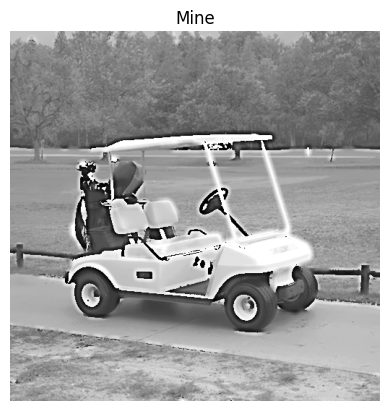

9/9 [==============================] - 1s 24ms/step


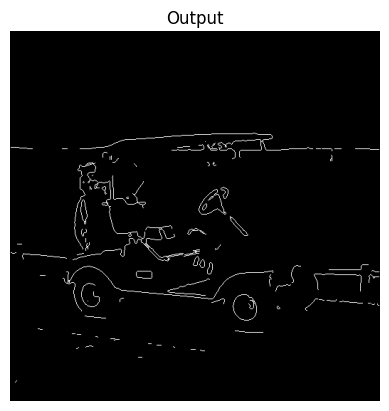

In [205]:
o1, o2 = detect_edges("C:\Ankit\Programs\RP\images\\golfcart.pgm", 'C:\Ankit\Programs\RP\models\ed_9x9.keras', 3, 2, 5, 1, 25, 7)
show_image(o1, "Output")

9/9 [==============================] - 1s 24ms/step
NN Edges: (520, 520), Time: 10.795479536056519s


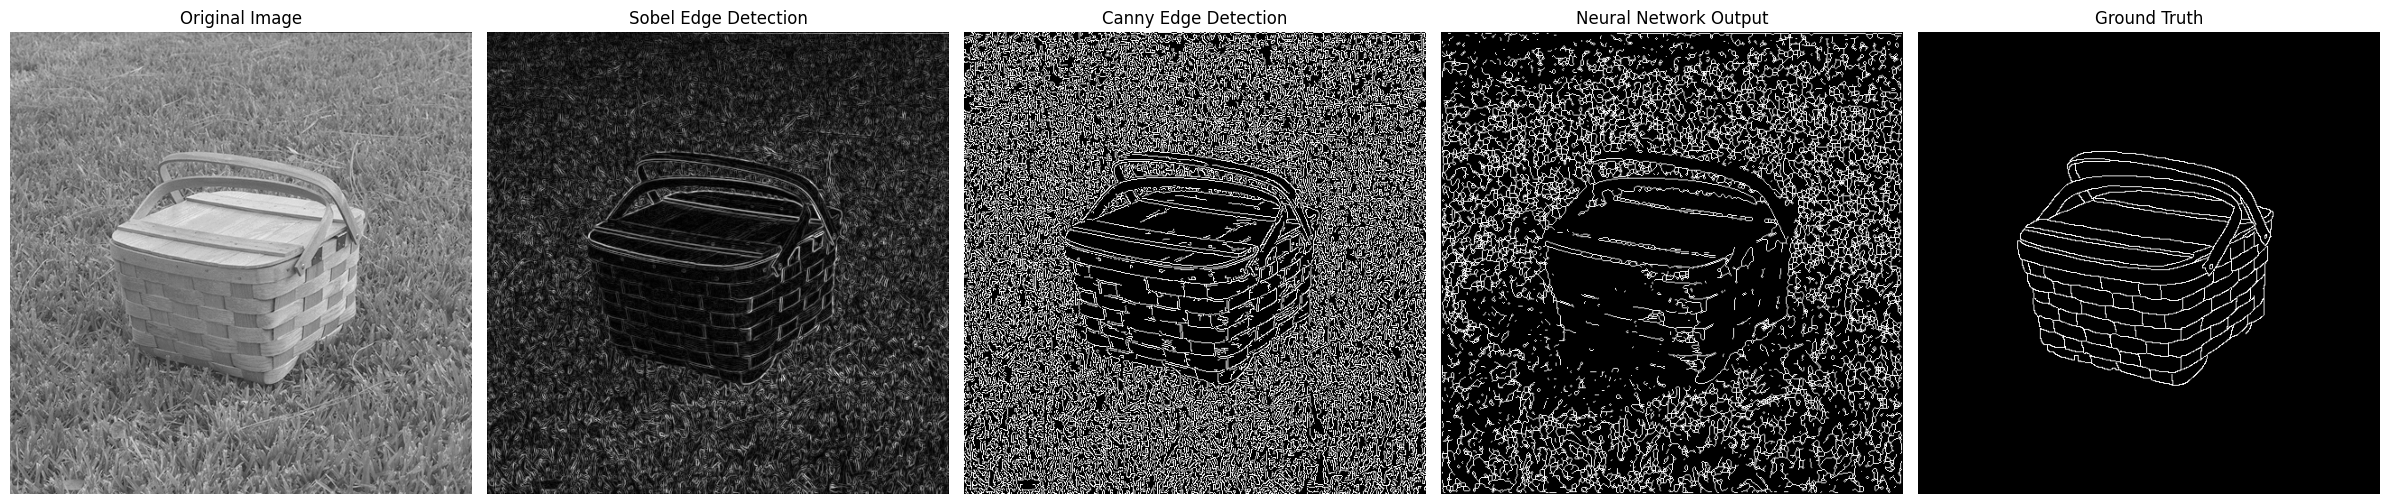

9/9 [==============================] - 1s 25ms/step
NN Edges: (520, 520), Time: 10.714038610458374s


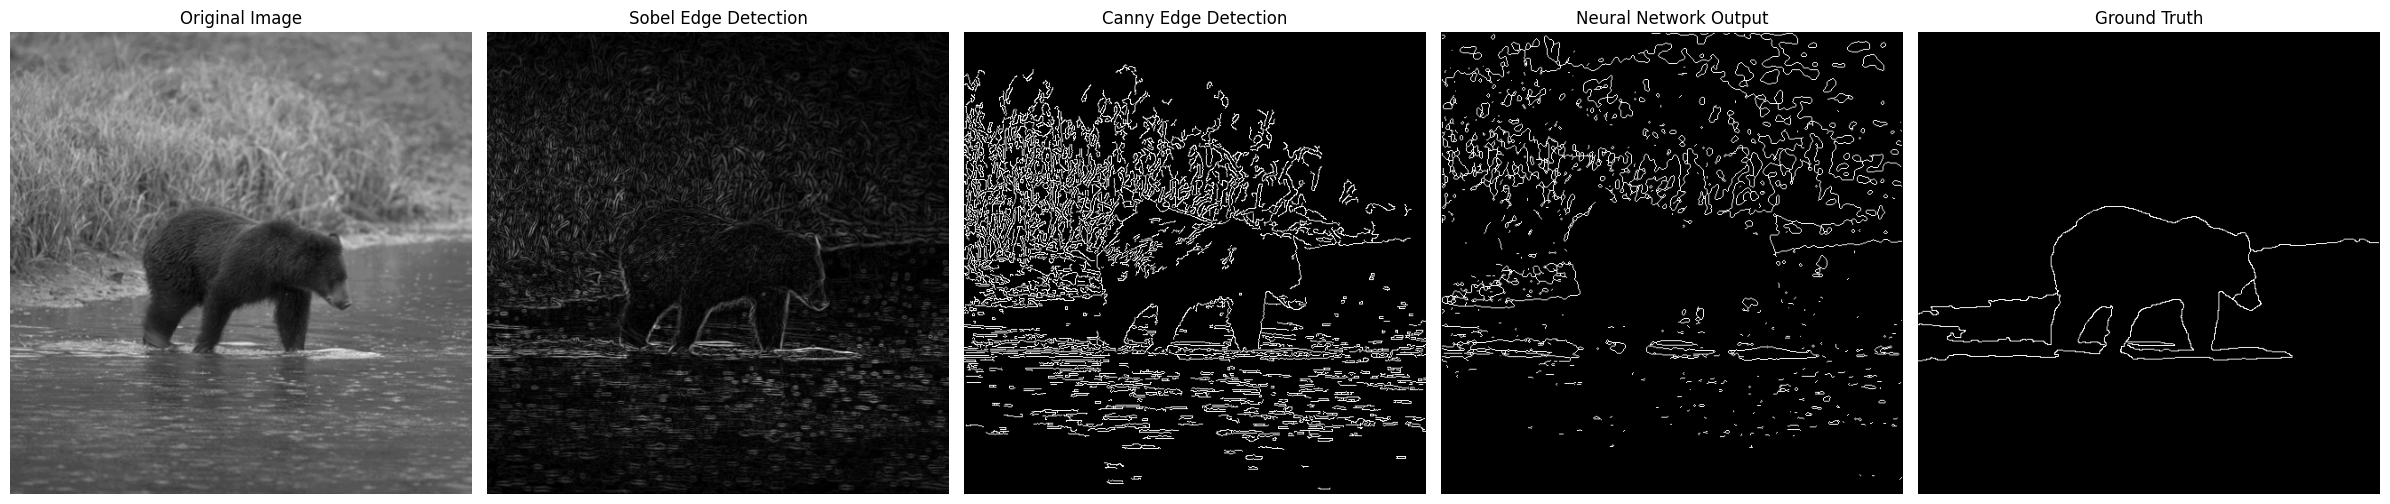

9/9 [==============================] - 1s 23ms/step
NN Edges: (520, 520), Time: 10.76009225845337s


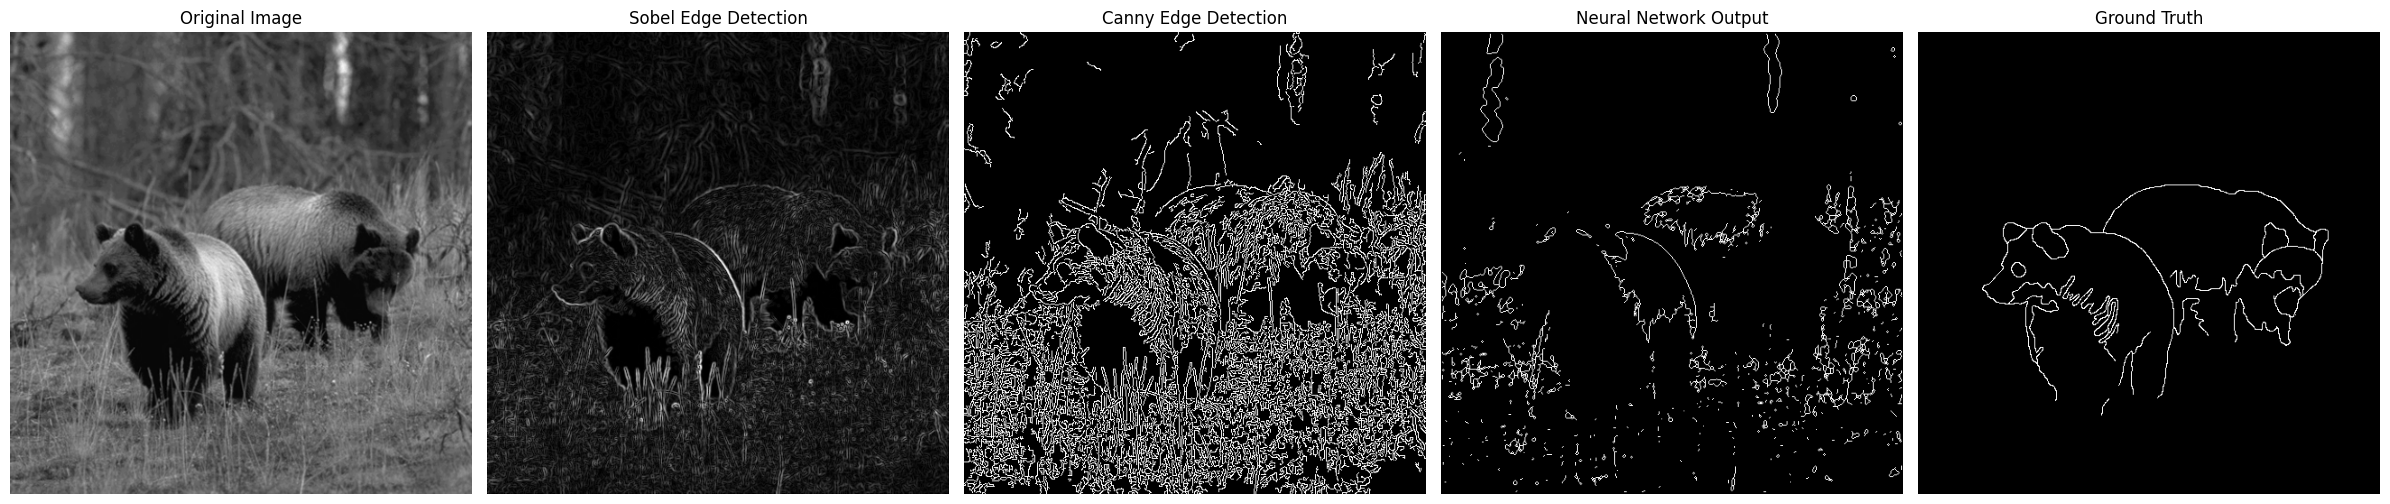

KeyboardInterrupt: 

In [ ]:
import os
import time

def detect_edges(image_path, model_path, block_size, C=2, min_size=5, step_size=1, jnd_value=25, jnd_window_size=7):
    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Preprocess the image
    image = pre_process(image_path, 9, C, jnd_window_size, jnd_value)
    orig_height, orig_width = image.shape
    # print(f"Original image shape: {image.shape}")
    
    # Extract sliding windows using sliding_window_view
    windows = sliding_window_view(image, (block_size, block_size))[:, ::step_size]
    num_rows, num_cols = windows.shape[0], windows.shape[1]
    num_windows = num_rows * num_cols
    # print(f"Number of windows: {num_rows} rows, {num_cols} cols")
    
    # Reshape for batch prediction
    windows_reshaped = windows.reshape(num_windows, block_size, block_size)
    windows_reshaped = tf.convert_to_tensor(windows_reshaped, dtype=tf.float32)
    windows_reshaped = tf.reshape(windows_reshaped, [-1, block_size * block_size, 1])
    
    # Model predictions
    preds = model.predict(windows_reshaped, batch_size=32768)
    # print(f"Prediction range: {preds[0][:, 0].min()} to {preds[0][:, 0].max()}")
    
    # Initialize output arrays
    output_1 = np.zeros((orig_height, orig_width), dtype=np.uint8)
    output_2 = np.zeros((orig_height, orig_width), dtype=np.uint8)
    
    # Process predictions
    binary_preds = preds[0][:, 0] > 0.7
    edge_type_1 = np.argmax(preds[1], axis=1)
    edge_type_2 = np.argmax(preds[2], axis=1)
    # print(f"Edges detected: {binary_preds.sum()} out of {binary_preds.size}")
    
    # Vectorized mapping to center pixels
    center_offset = block_size // 2
    row_indices = np.arange(num_rows) * step_size + center_offset
    col_indices = np.arange(num_cols) * step_size + center_offset
    rows, cols = np.meshgrid(row_indices, col_indices, indexing='ij')
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    
    valid_mask = (rows_flat < orig_height) & (cols_flat < orig_width)
    rows_valid = rows_flat[valid_mask]
    cols_valid = cols_flat[valid_mask]
    binary_preds_valid = binary_preds[valid_mask]
    edge_type_1_valid = edge_type_1[valid_mask]
    edge_type_2_valid = edge_type_2[valid_mask]
    
    # Assign to center pixels
    output_1[rows_valid, cols_valid] = binary_preds_valid * 255
    output_2[rows_valid, cols_valid] = (edge_type_1_valid * 10 + edge_type_2_valid) * binary_preds_valid
    # print(f"Output_1 non-zero pixels before post-processing: {(output_1 > 0).sum()}")
    
    # Post-process
    output_1 = post_process_edges(output_1, min_size)
    
    return output_1, output_2

# Unchanged pre_process and post_process_edges
def pre_process(image_path, block_size, C, jnd_window_size=9, jnd_value=48):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.fastNlMeansDenoising(image, h=2)
    
    # Apply JND mean threshold to all pixels
    jnd_image = jnd_threshold(image, window_size=jnd_window_size, jnd_value=jnd_value)
    
    # Apply adaptive threshold
    # thresh_img = cv2.adaptiveThreshold(
    #     jnd_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
    # )
    thresh_img = jnd_image
    adj_height = thresh_img.shape[0] + thresh_img.shape[0] % block_size
    adj_width = thresh_img.shape[1] + thresh_img.shape[1] % block_size
    thresh_img = cv2.resize(thresh_img, (adj_width, adj_height))
    # show_image(thresh_img, "Pre defined")
    # show_image(jnd_image, "Mine")
    
    return thresh_img / 255.0

def post_process_edges(edge_map, min_size):
    binary_edge_map = edge_map > 0
    cleaned_edge_map = remove_small_objects(binary_edge_map, min_size=min_size)
    thinned_edge_map = skeletonize(cleaned_edge_map)
    return (thinned_edge_map * 255).astype(np.uint8)

def let_me_see(images_dir, gt_dir, model_path, block_size=3, C=3, min_size=15, step_size=1):
    model = load_model(model_path)  # Load once for efficiency
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.pgm'))]
    num_images = len(image_files)
    
    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(images_dir, img_file)
        gt_path = os.path.join(gt_dir, img_file[:-4]+'_gt_binary.pgm')
        
        # # Load ground truth
        # gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        # if gt is None:
        #     print(f"Skipping {img_file} (GT not found)")
        #     continue
        
        # # Neural Network
        # gt = cv2.bitwise_not(gt)
        t_start = time.time()
        nn_edges, _ = detect_edges(img_path, model_path, block_size, C, min_size, step_size)
        image = cv2.imread(img_path)
        t_end = time.time()
        print(f"NN Edges: {nn_edges.shape}, Time: {t_end - t_start}s")
        # Compare
        compare_edge_detection(image, nn_edges, gt_path)
        
# let_me_see("C:\Ankit\Programs\RP\images", "C:\Ankit\Programs\RP\images\gt", 'C:\Ankit\Programs\RP\models\ed_9x9.keras', 3, 2, 5, 1)